In [58]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import os
import ali.methods
import ali.ui

In [94]:
for id in os.listdir('output/my'):
        if not "P" in id :continue
        
        hr,step,rhr,info=ali.methods.load(id)
        if info['covid_test_date']:
            print(f'{id}')
#             break
        
#         alarms = pd.read_csv(f'output/my/{id}/alarm.csv',parse_dates=['datetime'],index_col='datetime').fillna(0)
#         alarms['datetime'] = pd.to_datetime(alarms['datetime'])
#         alarms = alarms.set_index('datetime')
#         if not os.path.isfile(f'output/my/{id}/rhr.h5'):
#             continue
        
#         rhr = pd.read_hdf(f'output/my/{id}/rhr.h5', 'rhr',mode='r')
        
#         display(rhr)



P476443
P851598
P261190
P111019
P214671


KeyboardInterrupt: 

{'id': 'P277912', 'device': 'Fitbit', 'covid_test_date': Timestamp('2024-01-03 00:00:00'), 'symptom_date': Timestamp('2024-01-04 00:00:00')}


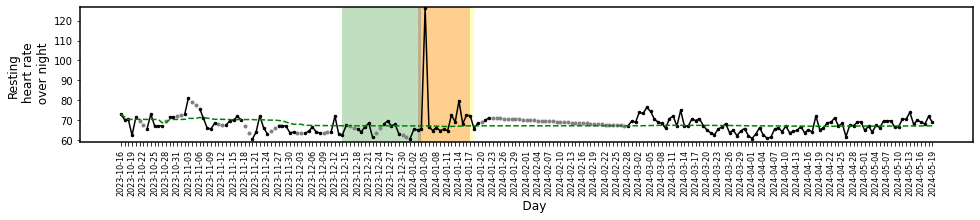

Training input shape:  (92341, 1260, 1)


In [139]:
id='P277912'
seg='1T'
TIME_STEPS =int(pd.to_timedelta('7h')/pd.to_timedelta(seg)*3)

hr,step,rhr,info=ali.methods.load(id)
print(info)
ali.ui.plot(rhr,alerts=pd.DataFrame(),info=info,show=True)
rhr1=rhr.resample(seg).mean().interpolate()
if info['covid_test_date']:
    if sum(rhr1.index<info['covid_test_date']-pd.to_timedelta('7d'))>TIME_STEPS*10:
        df_small_noise=rhr1.loc[rhr1.index<info['covid_test_date']-pd.to_timedelta('14d')]
        df_daily_jumpsup=rhr1.loc[rhr1.index>=info['covid_test_date']-pd.to_timedelta('14d')]
    else:
        df_small_noise = rhr1.loc[rhr1.index>info['covid_test_date']+pd.to_timedelta('14d')]
        df_daily_jumpsup = rhr1.loc[rhr1.index<=info['covid_test_date']+pd.to_timedelta('14d')]
    
else:
        df_small_noise=rhr1.loc[rhr1.index<rhr1.index[0]+pd.to_timedelta('28d')]
        df_daily_jumpsup=rhr1.loc[rhr1.index>=rhr1.index[0]+pd.to_timedelta('28d')]


# display(rhr)
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std



# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)


In [140]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 630, 32)           256       
                                                                 
 dropout_18 (Dropout)        (None, 630, 32)           0         
                                                                 
 conv1d_19 (Conv1D)          (None, 315, 16)           3600      
                                                                 
 conv1d_transpose_27 (Conv1D  (None, 630, 16)          1808      
 Transpose)                                                      
                                                                 
 dropout_19 (Dropout)        (None, 630, 16)           0         
                                                                 
 conv1d_transpose_28 (Conv1D  (None, 1260, 32)         3616      
 Transpose)                                           

Epoch 1/50
650/650 [==============================] - 107s 163ms/step - loss: 0.0383 - val_loss: 0.0218
Epoch 2/50
650/650 [==============================] - 94s 145ms/step - loss: 0.0057 - val_loss: 0.0305
Epoch 3/50
650/650 [==============================] - 107s 164ms/step - loss: 0.0041 - val_loss: 0.0284
Epoch 4/50
650/650 [==============================] - 105s 162ms/step - loss: 0.0033 - val_loss: 0.0285
Epoch 5/50
650/650 [==============================] - 99s 152ms/step - loss: 0.0028 - val_loss: 0.0384
Epoch 6/50
650/650 [==============================] - 100s 154ms/step - loss: 0.0024 - val_loss: 0.0489


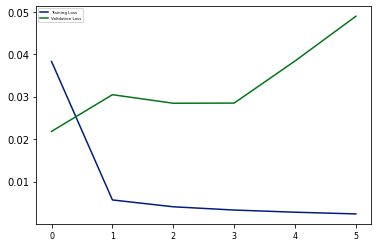

In [141]:

history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

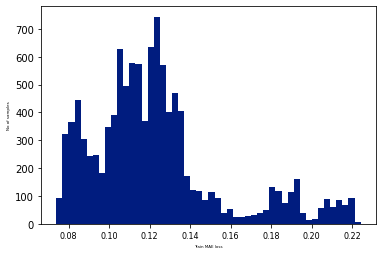

Reconstruction error threshold:  0.22412448029726942


In [134]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

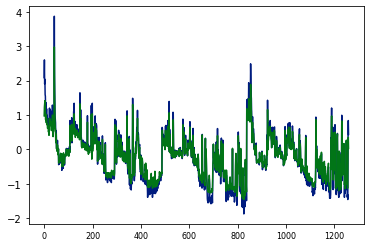

In [98]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()


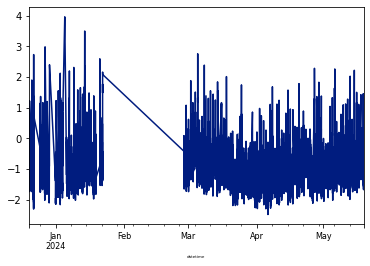

Test input shape:  (216601, 1260, 1)


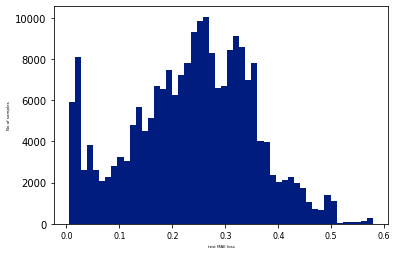

Number of anomaly samples:  124721
Indices of anomaly samples:  (array([  1963,   1965,   1966, ..., 213107, 213108, 213110]),)


In [142]:

df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [143]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if (sum(anomalies[data_idx - TIME_STEPS + 1 : data_idx]))>TIME_STEPS/6:
#     if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)
print(f'size={len(anomalous_data_indices)}')

size=148687


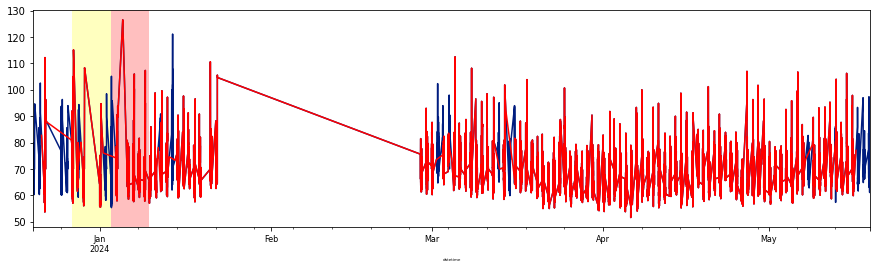

In [144]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
fig.set_figwidth(15)

df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")

if(info['covid_test_date']!=None):
        plt.axvspan(info['covid_test_date'], min(df_daily_jumpsup.index[-1], info['covid_test_date']+pd.to_timedelta('7d')), facecolor='red', alpha=0.25, label='Covid')
        plt.axvspan(info['covid_test_date'], max(df_daily_jumpsup.index[1], info['covid_test_date']-pd.to_timedelta('7d')), facecolor='yellow', alpha=0.25, label='Covid')
plt.show()

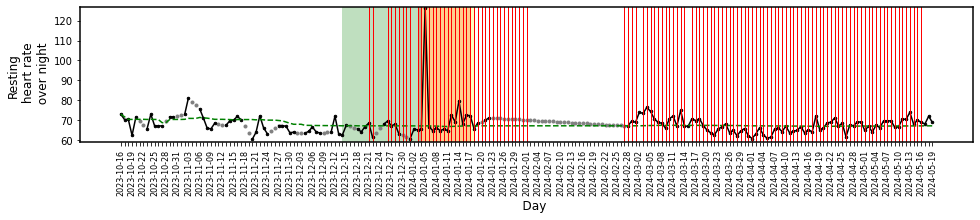

In [145]:
dates=df_daily_jumpsup.iloc[anomalous_data_indices].resample('1D').count().fillna(0).rename(columns={'heartrate':'count'})


dates['alarm']=(dates['count']>0)*2
ali.ui.plot(rhr,alerts=dates,info=info,show=True)